In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import gc
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from models import *
import torch.nn.functional as F
from i2sb.i2i_runner import Runner
from Datasets import *
from utils import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our Diffusion Layer is trained on a NAIP aerial imagery, which is 1m/pixel resolution imagery taken all over the US. It learns to map LR feature spaces of Sentinel-2 to the HR feature spaces of NAIP.

We now benchmark the trained Diffusion Layer's ability to map LR features spaces of Sentinel-2 to the HR feature spaces of 1mDrone from our Jamaica/Mexico expeditions.

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

TRAINED_DIFFUSION_RUNNER_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/model_001000.pt' # opt.load variable
TRAINED_DIFFUSION_RUNNER = torch.load(TRAINED_DIFFUSION_RUNNER_PATH, map_location=DEVICE) # contains keys: ['net', 'ema', 'optimizer', 'sched']

JAMAICA_RGB_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224img_drone.npy'
JAMAICA_SATELLITE_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224img_norm_satellite.npy'

NAIP_RGB_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_img_drone_V1.npy'
NAIP_SATELLITE_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_img_norm_satellite_V1.npy'

INTERVAL = 100 # number of reconstruction time intervals
# LOG_STEPS = [0, 111, 222, 333, 444, 554, 665, 776, 887, 998] # hardcoded - based on opt.interval of trained diffuser
LOG_STEPS = [0, 11, 22, 33, 44, 54, 65, 76, 87, 98] # hardcoded - based on opt.interval of trained diffuser

Using Apple Metal Performance Shaders (MPS) device.



In [3]:
# log layers of TRAINED_DIFFUSION_RUNNER['net']
for key in TRAINED_DIFFUSION_RUNNER['net'].keys():
  print(key)

encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.bn1.running_mean
encoder.4.0.bn1.running_var
encoder.4.0.bn1.num_batches_tracked
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.bn2.running_mean
encoder.4.0.bn2.running_var
encoder.4.0.bn2.num_batches_tracked
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.bn1.running_mean
encoder.4.1.bn1.running_var
encoder.4.1.bn1.num_batches_tracked
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.bn2.running_mean
encoder.4.1.bn2.running_var
encoder.4.1.bn2.num_batches_tracked
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.bn1.running_mean
encoder.5.0.bn1.running_var
encoder.5.0.bn1.num_batches_tracked
encoder.5.0.conv2.weight
encoder.5.0.bn2.weight
encoder.5.0.bn2.bi

In [4]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=INTERVAL,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=10001,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=TRAINED_DIFFUSION_RUNNER_PATH,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"


run = Runner(opt)

Image2ImageDiffusion(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [5]:
# setup naip and jamaica latent dataset and dataloaders

naip_rgb_latent = np.load(NAIP_RGB_PATH, 'r')
naip_satellite_latent = np.load(NAIP_SATELLITE_PATH, 'r')
# print(f"naip_rgb_latent dtype: {naip_rgb_latent.dtype}. min={naip_rgb_latent.min()} max={naip_rgb_latent.max()}")
# print(f"naip_satellite_latent dtype: {naip_satellite_latent.dtype}. min={naip_satellite_latent.min()} max={naip_satellite_latent.max()}")
assert len(naip_rgb_latent) == len(naip_satellite_latent), f"naip_rgb_latent b={naip_rgb_latent.shape[0]} and naip_satellite_latent b={naip_satellite_latent.shape[0]} don't have the same B"
print(f"naip_rgb_latent: {naip_rgb_latent.shape} | naip_satellite_latent shape: {naip_satellite_latent.shape}")

# naip_rgb_latent = torch.from_numpy(naip_rgb_latent).float()
# naip_satellite_latent = torch.from_numpy(naip_satellite_latent).float()
naip_dataset = Image2ImageDataset(naip_satellite_latent, naip_rgb_latent)
naip_loader = DataLoader(naip_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

jamaica_rgb_latent = np.load(JAMAICA_RGB_PATH, 'r')
jamaica_satellite_latent = np.load(JAMAICA_SATELLITE_PATH, 'r')
# print(f"jamaica_rgb_latent dtype: {jamaica_rgb_latent.dtype}. min={jamaica_rgb_latent.min()} max={jamaica_rgb_latent.max()}")
# print(f"jamaica_satellite_latent dtype: {jamaica_satellite_latent.dtype}. min={jamaica_satellite_latent.min()} max={jamaica_satellite_latent.max()}")
assert len(jamaica_rgb_latent) == len(jamaica_satellite_latent), f"jamaica_rgb_latent b={jamaica_rgb_latent.shape[0]} and jamaica_satellite_latent b={jamaica_satellite_latent.shape[0]} don't have the same B"
print(f"jamaica_rgb_latent: {jamaica_rgb_latent.shape} | jamaica_satellite_latent shape: {jamaica_satellite_latent.shape}")

# jamaica_rgb_latent = torch.from_numpy(jamaica_rgb_latent).float()
# jamaica_satellite_latent = torch.from_numpy(jamaica_satellite_latent).float()
jamaica_dataset = Image2ImageDataset(jamaica_satellite_latent, jamaica_rgb_latent)
jamaica_loader = DataLoader(jamaica_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

print(f"naip_loader of length {len(naip_loader)} and jamaica_loader of length {len(jamaica_loader)} created")

naip_rgb_latent: (45540, 3, 224, 224) | naip_satellite_latent shape: (45540, 12, 224, 224)
jamaica_rgb_latent: (584, 3, 224, 224) | jamaica_satellite_latent shape: (584, 12, 224, 224)
naip_loader of length 11385 and jamaica_loader of length 146 created


In [6]:
# Benchmark model's noise prediction loss on NAIP(what the model is trained on) vs jamaica(unseen data)
total_naip_noise_pred_loss = 0
total_jamaica_noise_pred_loss = 0

num_iters = 100 # 100 random microbatches of 4

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    bands = [3, 2, 1]
    naip_cond, naip_x0 = next(iter(naip_loader))
    naip_cond, naip_x0 = naip_cond.to(DEVICE), naip_x0.to(DEVICE)
    naip_x1 = naip_cond.clone()[:, bands, :, :]

    jamaica_cond, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_cond, jamaica_x0 = jamaica_cond.to(DEVICE), jamaica_x0.to(DEVICE)
    jamaica_x1 = jamaica_cond.clone()[:, bands, :, :]

    step = torch.randint(0, opt.interval, (naip_x0.shape[0],)).to(opt.device) 
    naip_xt = run.diffusion.q_sample(step, naip_x0, naip_x1, ot_ode=opt.ot_ode).to(opt.device) # intermediate noisy image
    jamaica_xt = run.diffusion.q_sample(step, jamaica_x0, jamaica_x1, ot_ode=opt.ot_ode).to(opt.device) # intermediate noisy image

    naip_multispectral_features = run.net.encoder(naip_cond)
    naip_gate = run.net.gate_embedding(step.view(-1, 1).float()).to(opt.device)
    naip_multispectral_cond = run.net.decoder(naip_multispectral_features * naip_gate.unsqueeze(2).unsqueeze(3))
    naip_pred = run.net.diffuser(naip_xt, naip_multispectral_cond, step) # predicted noise
    naip_label = run.compute_label(step, naip_x0, naip_xt) # ground truth noise
    naip_noise_pred_loss = F.mse_loss(naip_pred, naip_label)
    total_naip_noise_pred_loss += naip_noise_pred_loss

    jamaica_multispectral_features = run.net.encoder(jamaica_cond)
    jamaica_gate = run.net.gate_embedding(step.view(-1, 1).float()).to(opt.device)
    jamaica_multispectral_cond = run.net.decoder(jamaica_multispectral_features * jamaica_gate.unsqueeze(2).unsqueeze(3))
    jamaica_pred = run.net.diffuser(jamaica_xt, jamaica_multispectral_cond, step) # predicted noise
    jamaica_label = run.compute_label(step, jamaica_x0, jamaica_xt) # ground truth noise
    jamaica_noise_pred_loss = F.mse_loss(jamaica_pred, jamaica_label)
    total_jamaica_noise_pred_loss += jamaica_noise_pred_loss

avg_naip_noise_pred_loss = total_naip_noise_pred_loss / num_iters
avg_jamaica_noise_pred_loss = total_jamaica_noise_pred_loss / num_iters

print(f"avg_naip_noise_pred_loss={avg_naip_noise_pred_loss} | avg_jamaica_noise_pred_loss={avg_jamaica_noise_pred_loss}")

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


avg_naip_noise_pred_loss=15626.21484375 | avg_jamaica_noise_pred_loss=30451.349609375


In [8]:
# Benchmark model's reconstruction loss on NAIP(what the model is trained on) vs jamaica(unseen data)
total_naip_reconstruction_loss = 0
total_jamaica_reconstruction_loss = 0

num_iters = 100 # 100 random microbatches of 4

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    bands = [3, 2, 1]
    naip_cond, naip_x0 = next(iter(naip_loader))
    naip_cond, naip_x0 = naip_cond.to(DEVICE), naip_x0.to(DEVICE)
    naip_x1 = naip_cond.clone()[:, bands, :, :]

    jamaica_cond, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_cond, jamaica_x0 = jamaica_cond.to(DEVICE), jamaica_x0.to(DEVICE)
    jamaica_x1 = jamaica_cond.clone()[:, bands, :, :]

    step = torch.randint(0, opt.interval, (naip_x0.shape[0],)).to(opt.device)

    naip_multispectral_features = run.net.encoder(naip_cond)
    naip_gate = run.net.gate_embedding(step.view(-1, 1).float()).to(opt.device)
    naip_multispectral_cond = run.net.decoder(naip_multispectral_features * naip_gate.unsqueeze(2).unsqueeze(3))

    naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, cond=naip_multispectral_cond, clip_denoise=opt.clip_denoise, verbose=False)
    naip_x0_hat = naip_pred_x0s[:, -1].to(opt.device)
    naip_reconstrution_loss = F.mse_loss(naip_x0_hat, naip_x0.float())
    total_naip_reconstruction_loss += naip_reconstrution_loss.item()

    jamaica_multispectral_features = run.net.encoder(jamaica_cond)
    jamaica_gate = run.net.gate_embedding(step.view(-1, 1).float()).to(opt.device)
    jamaica_multispectral_cond = run.net.decoder(jamaica_multispectral_features * jamaica_gate.unsqueeze(2).unsqueeze(3))

    jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, cond=jamaica_multispectral_cond, clip_denoise=opt.clip_denoise, verbose=False)
    jamaica_x0_hat = jamaica_pred_x0s[:, -1].to(opt.device)
    jamaica_reconstrution_loss = F.mse_loss(jamaica_x0_hat, jamaica_x0.float())
    total_jamaica_reconstruction_loss += jamaica_reconstrution_loss.item()
    

avg_naip_reconstruction_loss = total_naip_reconstruction_loss / num_iters
avg_jamaica_reconstruction_loss = total_jamaica_reconstruction_loss / num_iters

print(f"avg_naip_reconstruction_loss={avg_naip_reconstruction_loss} | avg_jamaica_reconstruction_loss={avg_jamaica_reconstruction_loss}")

avg_naip_reconstruction_loss=1490.438907775879 | avg_jamaica_reconstruction_loss=3067.5350036621094


torch.Size([4, 10, 3, 224, 224])
naip_loss_per_step (clean to noisy): [3069.550048828125, 2552.988525390625, 2236.736083984375, 2080.478271484375, 2025.3853759765625, 2026.2996826171875, 2046.1431884765625, 2073.86572265625, 2100.65625, 2125.409912109375]
torch.Size([4, 10, 3, 224, 224])
naip_loss_per_step (clean to noisy): [1820.93408203125, 1416.6671142578125, 1186.5865478515625, 1086.9339599609375, 1067.490478515625, 1080.0814208984375, 1096.923583984375, 1110.0504150390625, 1117.2489013671875, 1122.538818359375]
torch.Size([4, 10, 3, 224, 224])


IndexError: list index out of range

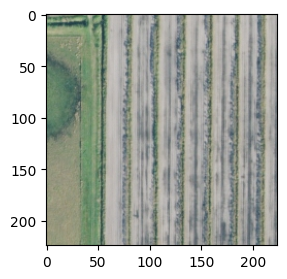

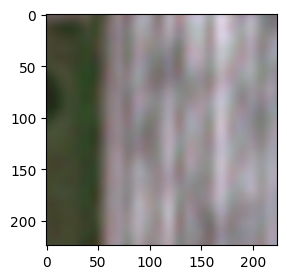

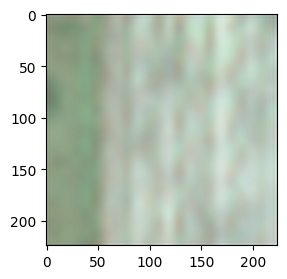

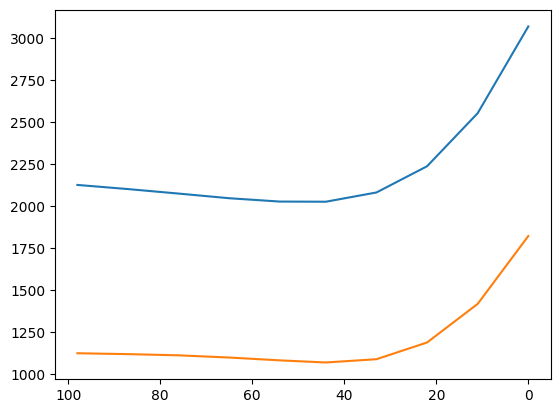

In [19]:
num_batches = 10
naip_reconstruction_loss_arr = []

run.net.eval()
with torch.no_grad():
  for n in range(num_batches):
    bands = [3, 2, 1]
    naip_cond, naip_x0 = next(iter(naip_loader))
    naip_cond, naip_x0 = naip_cond.to(DEVICE), naip_x0.to(DEVICE)
    naip_x1 = naip_cond.clone()[:, bands, :, :]

    step = torch.randint(0, opt.interval, (naip_x0.shape[0],)).to(opt.device)

    naip_multispectral_features = run.net.encoder(naip_cond)
    naip_gate = run.net.gate_embedding(step.view(-1, 1).float()).to(opt.device)
    naip_multispectral_cond = run.net.decoder(naip_multispectral_features * naip_gate.unsqueeze(2).unsqueeze(3))
    naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, cond=naip_multispectral_cond, clip_denoise=opt.clip_denoise, verbose=False)
    naip_pred_x0s = naip_pred_x0s.to(opt.device)
    print(naip_pred_x0s.shape)

    # plot ground truth vs diffused
    if (n == 2):
        batch_idx = 0
        naip_x0_hat = naip_pred_x0s[:, -1]

        fig, ax = plt.subplots(figsize=(3, 3))
        show(np.clip(naip_x0[batch_idx].cpu().numpy(), 0, 255).astype(np.uint8) ,ax=ax)

        fig, ax = plt.subplots(figsize=(3, 3))
        show(np.clip(naip_x1[batch_idx].cpu().numpy(), 0, 255).astype(np.uint8) ,ax=ax)

        fig, ax = plt.subplots(figsize=(3, 3))
        show(np.clip(naip_x0_hat[batch_idx].cpu().numpy(), 0, 255).astype(np.uint8) ,ax=ax)
        break
    

    B, numSteps, C, H, W = naip_pred_x0s.shape
    naip_loss_per_step = []

    for s in range(numSteps):
      # pred_x0s[:,s] is (B, C, H, W)
      naip_reconstruction_loss = F.mse_loss(naip_pred_x0s[:,s], naip_x0.float())
      naip_loss_per_step.append(naip_reconstruction_loss.item())

    naip_loss_per_step.reverse()

    print(f"naip_loss_per_step (clean to noisy): {naip_loss_per_step}")

    naip_reconstruction_loss_arr.append(naip_loss_per_step)

plt.figure()
plt.gca().invert_xaxis()
for n in range(num_batches):
    plt.plot(LOG_STEPS, naip_reconstruction_loss_arr[n])
plt.xlabel("Timestep")
plt.ylabel("Reconstruction MSE Loss")
plt.xlim(LOG_STEPS[-1], LOG_STEPS[0])
plt.ylim(0)
plt.title(f"NAIP reconstruction loss vs. t ({num_batches} random batches)")
plt.grid(True)
plt.show()

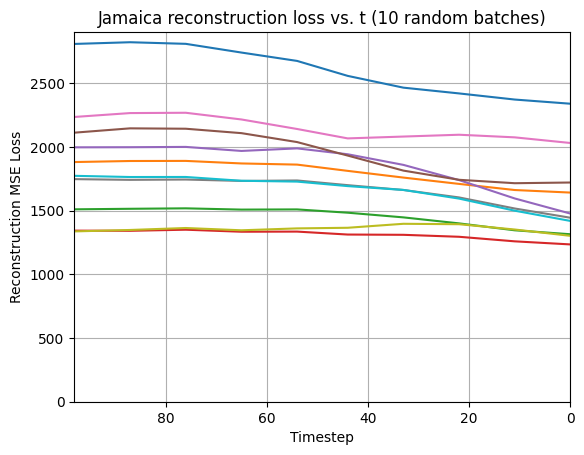

In [12]:
num_batches = 10
jamaica_reconstruction_loss_arr = []

run.net.eval()
with torch.no_grad():
  for n in range(num_batches):
    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE).float(), jamaica_x0.to(DEVICE).float()

    jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, clip_denoise=opt.clip_denoise, verbose=False)
    jamaica_pred_x0s = jamaica_pred_x0s.to(opt.device)

    B, numSteps, C, H, W = jamaica_pred_x0s.shape
    jamaica_loss_per_step = []

    for s in range(numSteps):
      # pred_x0s[:,s] is (B, C, H, W)
      jamaica_reconstruction_loss = F.mse_loss(jamaica_pred_x0s[:,s], jamaica_x0)
      jamaica_loss_per_step.append(jamaica_reconstruction_loss.item())

    jamaica_loss_per_step.reverse()

    # print(f"jamaica_loss_per_step (clean to noisy): {jamaica_loss_per_step}")

    jamaica_reconstruction_loss_arr.append(jamaica_loss_per_step)

plt.figure()
plt.gca().invert_xaxis()
for n in range(num_batches):
    plt.plot(LOG_STEPS, jamaica_reconstruction_loss_arr[n])
plt.xlabel("Timestep")
plt.ylabel("Reconstruction MSE Loss")
plt.xlim(LOG_STEPS[-1], LOG_STEPS[0])
plt.ylim(0)
plt.title(f"Jamaica reconstruction loss vs. t ({num_batches} random batches)")
plt.grid(True)
plt.show()